In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from google.colab import files

In [32]:
# Load clustered NBA data
nba_clustered = pd.read_csv("NBA_Train_Clustered.csv")
print(f"✓ NBA data: {len(nba_clustered)} players")
print(f"  Columns: {nba_clustered.columns.tolist()[:5]}...")

# Load college data
ncaa_train = pd.read_csv("College2000_2020.csv")
print(f"✓ NCAA data: {len(ncaa_train)} players")
print(f"  Columns: {ncaa_train.columns.tolist()[:5]}...")

# Merge on player name
merged_train = pd.merge(
    ncaa_train,
    nba_clustered[['PLAYER', 'Cluster', 'Cluster_Label']],
    left_on='Name',
    right_on='PLAYER',
    how='inner'
)

print(f"\n✓ Merged: {len(merged_train)} players with both college and NBA data")

# Show cluster distribution
print("\nCluster distribution:")
print(merged_train['Cluster_Label'].value_counts())

# Show sample
print("\nSample of merged data:")
print(merged_train[['Name', 'PTS', 'TRB', 'AST', 'Cluster_Label']].head(10))

✓ NBA data: 1018 players
  Columns: ['PLAYER', 'GP', 'MIN', 'PTS', 'REB']...
✓ NCAA data: 841 players
  Columns: ['G', 'GS', 'MP', 'FG', 'FGA']...

✓ Merged: 735 players with both college and NBA data

Cluster distribution:
Cluster_Label
Bust           225
Role Player    217
Bench          130
Superstar       98
Starter         65
Name: count, dtype: int64

Sample of merged data:
               Name   PTS   TRB  AST Cluster_Label
0     Allen Iverson  23.0   3.6  4.6     Superstar
1  Jerry Stackhouse  15.7   6.6  2.3     Superstar
2      Vince Carter  12.3   4.5  1.9   Role Player
3      Chris Webber  17.4  10.0  2.4     Superstar
4       Paul Pierce  16.4   6.3  2.2     Superstar
5    Antawn Jamison  19.0   9.9  0.9       Starter
6   Stephon Marbury  18.9   3.1  4.5     Superstar
7    Antoine Walker  11.7   6.5  2.2     Superstar
8       Karl Malone  18.7   9.3  1.4     Superstar
9       Gary Payton  18.1   4.0  7.8     Superstar


In [33]:
# Define college features (adjust based on your NCAA columns)
college_features = [
    'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
    'FT', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS'
]

# Check which features exist
available_features = [f for f in college_features if f in merged_train.columns]
print(f"✓ Available features ({len(available_features)}): {available_features}")

# Create X and y
X = merged_train[available_features].copy()
y = merged_train['Cluster'].copy()

# Handle missing values
X = X.fillna(X.mean())

print(f"\n✓ Feature matrix: {X.shape}")
print(f"✓ Target classes: {sorted(y.unique())}")
print(f"\nTarget distribution:")
print(y.value_counts().sort_index())

✓ Available features (17): ['G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']

✓ Feature matrix: (735, 17)
✓ Target classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]

Target distribution:
Cluster
0     98
1     65
2    217
3    130
4    225
Name: count, dtype: int64


In [34]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✓ Training: {len(X_train)} samples")
print(f"✓ Testing: {len(X_test)} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✓ Features scaled (mean=0, std=1)")

✓ Training: 588 samples
✓ Testing: 147 samples
✓ Features scaled (mean=0, std=1)


In [35]:
# Train model
log_reg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)

log_reg.fit(X_train_scaled, y_train)

print("✓ Model trained!")

# Make predictions
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

# Calculate accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\n Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f" Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

✓ Model trained!

 Training Accuracy: 0.5357 (53.57%)
 Test Accuracy: 0.4694 (46.94%)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [36]:
cluster_names = ['Superstar', 'All-Star', 'Role Player', 'Bench', 'Bust']

print(classification_report(y_test, y_test_pred,
                          target_names=cluster_names,
                          digits=3))

              precision    recall  f1-score   support

   Superstar      0.286     0.400     0.333        20
    All-Star      0.364     0.615     0.457        13
 Role Player      0.515     0.395     0.447        43
       Bench      0.556     0.577     0.566        26
        Bust      0.568     0.467     0.512        45

    accuracy                          0.469       147
   macro avg      0.458     0.491     0.463       147
weighted avg      0.494     0.469     0.474       147



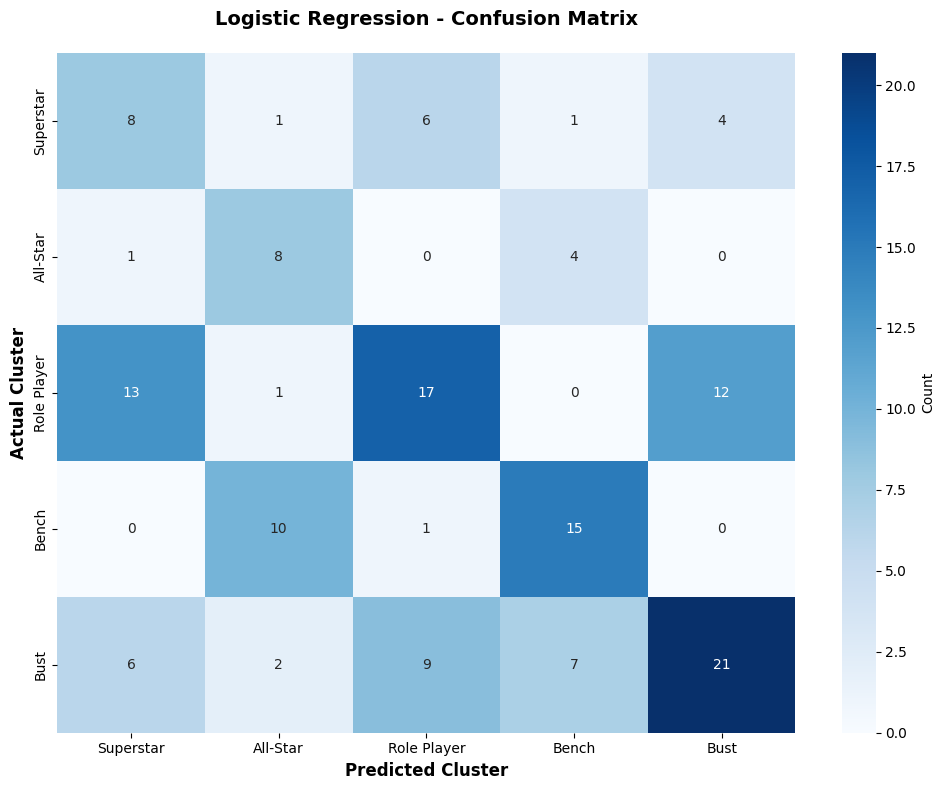


Confusion Matrix (Actual vs Predicted):
                    Pred Superstar  Pred All-Star  Pred Role Player  \
Actual Superstar                 8              1                 6   
Actual All-Star                  1              8                 0   
Actual Role Player              13              1                17   
Actual Bench                     0             10                 1   
Actual Bust                      6              2                 9   

                    Pred Bench  Pred Bust  
Actual Superstar             1          4  
Actual All-Star              4          0  
Actual Role Player           0         12  
Actual Bench                15          0  
Actual Bust                  7         21  


In [37]:
cm = confusion_matrix(y_test, y_test_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=cluster_names,
            yticklabels=cluster_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Actual Cluster', fontsize=12, fontweight='bold')
plt.title('Logistic Regression - Confusion Matrix',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix (Actual vs Predicted):")
cm_df = pd.DataFrame(cm,
                     index=[f"Actual {n}" for n in cluster_names],
                     columns=[f"Pred {n}" for n in cluster_names])
print(cm_df)


 Top 10 Most Important Features:
Feature  Importance
    BLK    0.619898
     MP    0.538068
    FGA    0.518722
     3P    0.459485
    3PA    0.429468
    AST    0.429076
    FTA    0.403165
    PTS    0.344207
     FG    0.325505
     FT    0.322254


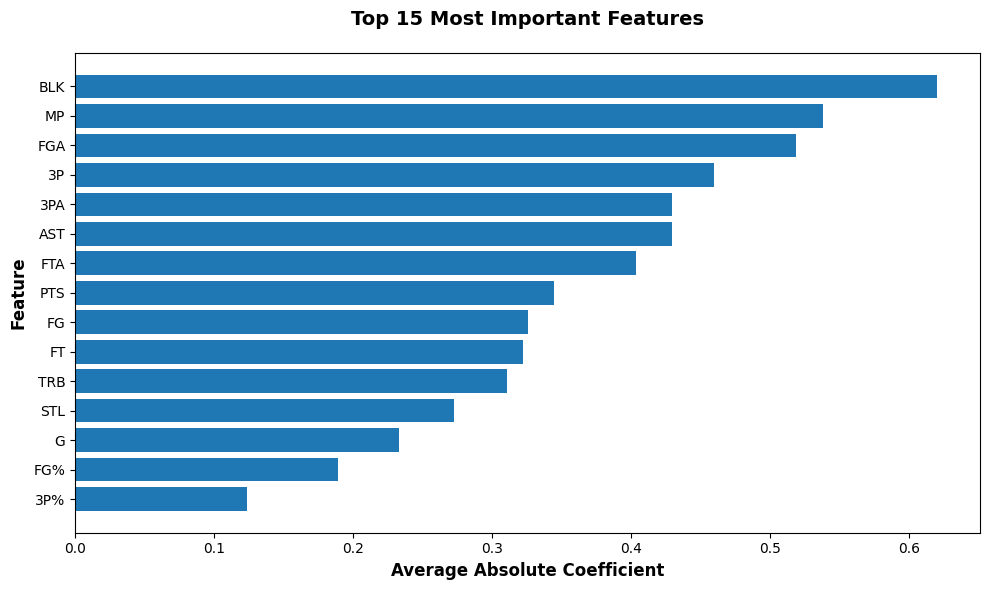

In [38]:
# Calculate feature importance
feature_importance = pd.DataFrame({
    'Feature': available_features,
    'Importance': np.abs(log_reg.coef_).mean(axis=0)
}).sort_values('Importance', ascending=False)

print("\n Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
top_n = 15
top_features = feature_importance.head(top_n)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Average Absolute Coefficient', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Most Important Features',
          fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [39]:
print(f"Model: Logistic Regression (Multinomial)")
print(f"Total Players: {len(merged_train)}")
print(f"Training Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")
print(f"Number of Features: {len(available_features)}")
print(f"Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

Model: Logistic Regression (Multinomial)
Total Players: 735
Training Samples: 588
Test Samples: 147
Number of Features: 17
Training Accuracy: 0.5357 (53.57%)
Test Accuracy: 0.4694 (46.94%)


# Testing with NBA players from 2020-2025

 Test set: 91 players

 Test Accuracy for NBA Players (2020-2025): 0.2967 (29.67%)
              precision    recall  f1-score   support

   Superstar      0.571     0.632     0.600        19
    All-Star      0.385     1.000     0.556         5
 Role Player      0.391     0.333     0.360        27
       Bench      0.250     0.026     0.048        38
        Bust      0.000     0.000     0.000         2

    accuracy                          0.297        91
   macro avg      0.319     0.398     0.313        91
weighted avg      0.361     0.297     0.282        91



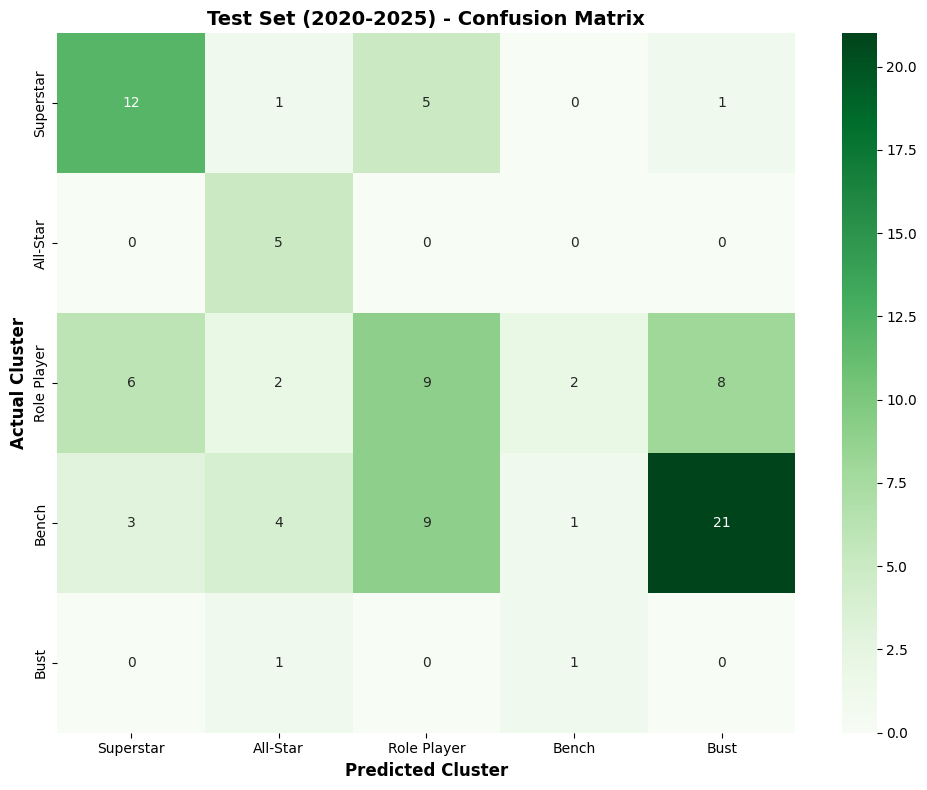

PREDICTION EXAMPLES

 Correct Predictions:
           Name  PTS    Cluster_Label Predicted_Label
  Deandre Ayton 20.1 All-Star/Starter        All-Star
    Buddy Hield 17.4      Role Player     Role Player
 Andrew Wiggins 17.1      Role Player     Role Player
 Markelle Fultz 23.2        Superstar       Superstar
Cade Cunningham 20.1        Superstar       Superstar
  Rui Hachimura 12.1      Role Player     Role Player
 Walker Kessler  8.2 All-Star/Starter        All-Star
    Ayo Dosunmu 16.7      Role Player     Role Player
      Zach Edey 18.2 All-Star/Starter        All-Star
   Jock Landale 13.2            Bench           Bench

 Incorrect Predictions:
            Name  PTS Cluster_Label Predicted_Label
      Jaden Ivey 14.9   Role Player            Bust
    Semi Ojeleye 12.3         Bench            Bust
     Cody Martin  9.7         Bench            Bust
  Quentin Grimes 12.5   Role Player            Bust
   Johnny Juzang 11.6         Bench            Bust
   Jalen Brunson 14.4     

In [45]:
# Load data
ncaa_test = pd.read_csv("NCAA_2020_2025.csv")
nba_test_clustered = pd.read_csv("NBA_Test_Clustered.csv")

# Merge
merged_test = pd.merge(
    ncaa_test,
    nba_test_clustered[['PLAYER', 'Cluster', 'Cluster_Label']],
    left_on='Name',
    right_on='PLAYER',
    how='inner'
)

print(f" Test set: {len(merged_test)} players")

# Prepare features
X_test_real = merged_test[available_features].copy()
y_test_real = merged_test['Cluster'].copy()
X_test_real = X_test_real.fillna(X_test_real.mean())

# Scale
X_test_real_scaled = scaler.transform(X_test_real)

# Predict
y_test_real_pred = log_reg.predict(X_test_real_scaled)

# Evaluate
test_acc_real = accuracy_score(y_test_real, y_test_real_pred)

print(f"\n Test Accuracy for NBA Players (2020-2025): {test_acc_real:.4f} ({test_acc_real*100:.2f}%)")

print(classification_report(y_test_real, y_test_real_pred,
                          target_names=cluster_names,
                          digits=3))

# Confusion Matrix
cm_test = confusion_matrix(y_test_real, y_test_real_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=cluster_names,
            yticklabels=cluster_names)
plt.xlabel('Predicted Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Actual Cluster', fontsize=12, fontweight='bold')
plt.title('Test Set (2020-2025) - Confusion Matrix',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("PREDICTION EXAMPLES")

merged_test['Predicted_Cluster'] = y_test_real_pred
merged_test['Predicted_Label'] = [cluster_names[p] for p in y_test_real_pred]
merged_test['Correct'] = merged_test['Cluster'] == merged_test['Predicted_Cluster']

print("\n Correct Predictions:")
correct = merged_test[merged_test['Correct'] == True].sample(min(10, len(merged_test)))
print(correct[['Name', 'PTS', 'Cluster_Label', 'Predicted_Label']].to_string(index=False))

print("\n Incorrect Predictions:")
incorrect = merged_test[merged_test['Correct'] == False].sample(min(10, len(merged_test[merged_test['Correct'] == False])))
print(incorrect[['Name', 'PTS', 'Cluster_Label', 'Predicted_Label']].to_string(index=False))

In [49]:

aging_vets = [
    'LeBron James', 'Kevin Durant', 'Stephen Curry', 'James Harden',
    'Russell Westbrook', 'Chris Paul', 'Carmelo Anthony', 'Klay Thompson',
    'Kawhi Leonard', 'Paul George', 'Jimmy Butler', 'Kyle Lowry',
    'DeMar DeRozan', 'Kevin Love', 'Blake Griffin', 'Al Horford',
    'Jeff Teague', 'George Hill', 'Marc Gasol', 'Dwight Howard', 'Jamal Murray', 'Georges Niang', 'Marcus Smart', 'Andrew Wiggins',
    'Buddy Hield', 'Trae Young', 'Malik Monk', 'Markelle Fultz', 'Jordan Clarkson', 'Seth Curry', 'Trey Burke', 'Delon Wright',
    'Julius Randle', 'Bobby Portis', 'Zion Williamson', 'Ben Simmons', 'Jalen Brunson', 'Lonzo Ball'
]

# Statistical exclusion (high college scorer + low NBA label = aging vet)
suspicious = merged_test[
    (merged_test['PTS'] >= 20) &
    (merged_test['Cluster_Label'].isin(['Role Player', 'Bench']))
]['Name'].tolist()

print(f"Manual exclusion list: {len(aging_vets)} players")
print(f"Statistical exclusion: {len(suspicious)} players")

# Combine lists
all_exclusions = list(set(aging_vets + suspicious))
print(f"Total exclusions: {len(all_exclusions)} unique players")

# Filter
merged_test_young = merged_test[~merged_test['Name'].isin(all_exclusions)].copy()

print(f"\n Results:")
print(f"Original test set: {len(merged_test)} players")
print(f"Young players set: {len(merged_test_young)} players")
print(f"Removed: {len(merged_test) - len(merged_test_young)} players")

excluded = merged_test[merged_test['Name'].isin(all_exclusions)]
if len(excluded) > 0:
    print(f"\n Excluded players:")
    print(excluded[['Name', 'PTS', 'Cluster_Label']].sort_values('PTS', ascending=False).to_string(index=False))

# Show young players distribution
print(f"\n Young players cluster distribution:")
print(merged_test_young['Cluster_Label'].value_counts())

# Show sample of remaining players
print(f"\n Sample of young players:")
print(merged_test_young[['Name', 'PTS', 'TRB', 'AST', 'Cluster_Label']].sort_values('PTS', ascending=False).head(20).to_string(index=False))

Manual exclusion list: 38 players
Statistical exclusion: 1 players
Total exclusions: 38 unique players

 Results:
Original test set: 91 players
Young players set: 65 players
Removed: 26 players

 Excluded players:
           Name  PTS Cluster_Label
     Trae Young 27.4     Superstar
   Kevin Durant 25.8     Superstar
  Stephen Curry 25.3     Superstar
 Markelle Fultz 23.2     Superstar
Zion Williamson 22.6     Superstar
Carmelo Anthony 22.2   Role Player
   Jamal Murray 20.0     Superstar
     Malik Monk 19.8   Role Player
    Ben Simmons 19.2     Superstar
   James Harden 19.0     Superstar
     Kevin Love 17.5         Bench
    Buddy Hield 17.4   Role Player
 Andrew Wiggins 17.1   Role Player
     Trey Burke 16.9         Bench
   Marcus Smart 16.6     Superstar
    Jeff Teague 16.4         Bench
  Georges Niang 16.1         Bench
Jordan Clarkson 15.4   Role Player
   Bobby Portis 15.0   Role Player
   Delon Wright 15.0   Role Player
     Chris Paul 15.0     Superstar
  Julius Randle 